In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

# Підготовка даних

1. Імпортувати дані
2. Виділити відгук і регресори
3. За потреби - почистити від сміття або імплементувати заповнення пробілів так, щоб моделювання не втратило сенс
4. Розбити вибірку на train/validation
5. Дослідити тренувальну вибірку

In [2]:
# import data
cars = pd.read_csv("CarPrice_Assignment.csv")
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
# define x, y
x = cars.highwaympg
y = cars.price

In [4]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42
)

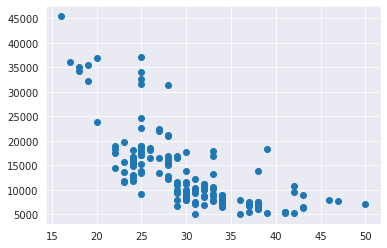

In [5]:
# visualize
plt.scatter(x_train, y_train)

# Побудова лінійної моделі методом МНК

1. Побудувати МНК на тренувальних даних
2. Оцінити якість моделі на тренувальній вибірці
    - середньоквадратична помилка (MSE)
    - $R^2$
    - тест Фішера
    - тест Стьюдента
3. Оцінити якість моделі на валідаційній вибірці
    - середньоквадратична помилка (MSE)
    - $R^2$
4. Зробити висновки

In [6]:
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

In [7]:
# fit the model
ols_model = sm.OLS(y_train, x_train).fit()

In [8]:
y_hat_train = ols_model.predict(x_train)
y_hat_test = ols_model.predict(x_test)

In [9]:
# model quality
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     168.0
Date:                Thu, 06 Apr 2023   Prob (F-statistic):           8.17e-27
Time:                        19:34:55   Log-Likelihood:                -1642.5
No. Observations:                 164   AIC:                             3289.
Df Residuals:                     162   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.948e+04   2069.998     19.073      0.000    3.54e+04    4.36e+04
highwaympg  -858.8607     66.263    -12.961      0.000    -989.712    -728.010
==============================================================================
Omnibus:                       48.407   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.030
Skew:                           1.442   Prob(JB):                     1.26e-19
Kurtosis:                       5.103   Cond. No.                         152.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
metrics.r2_score(y_test, y_hat_test)

0.408418318059692

In [11]:
metrics.mean_squared_error(y_train, y_hat_train), \
    metrics.mean_squared_error(y_test, y_hat_test)

(29277035.77265641, 46701836.65111868)

/home/olga/Projects/CPI/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


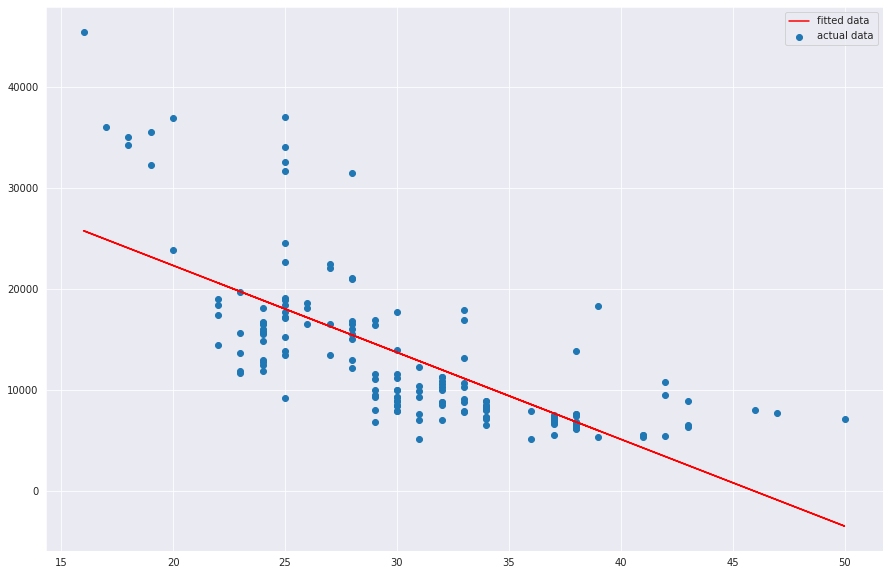

In [12]:
# additional image for understanding
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x_train.highwaympg, y_train, label="actual data")
ax.plot(x_train.highwaympg, y_hat_train, color="red", label="fitted data")
ax.legend()
fig.show()

# Побудова рідж-моделі

1. Визначити варіанти гіперпараметрів для вибору
2. Перебрати гіперпараметри. Для кожної $\lambda$ на тренувальній вибірці:
    - Побудувати рідж-модель з використанням $\lambda$ з п.1
    - Оцінити якість моделі (наприклад, за допомогою MSE або $R^2$)
3. Обрати гіперпараметр і модель з найкращими показниками на тренувальній вибірці
4. Оцінити якість обраної моделі на валідаційній вибірці
5. Зробити висновки

In [13]:
# hyperparams list
lambdas = [1, 0.5, 0.1, 0.05, 0.001]

In [14]:
# train different models
r2_scores = []
for l in lambdas:
    ridge_model = sm.OLS(y_train, x_train).fit_regularized(alpha=l, L1_wt=0)
    y_hat_train = ridge_model.predict(x_train)
    r2_scores.append(
        metrics.r2_score(y_train, y_hat_train)
    )
r2_scores

[-0.505362925202866,
 -0.428049219175364,
 -0.036261536594972776,
 0.1846231322318892,
 0.5084941041968747]

In [15]:
# select model
ridge_model = sm.OLS(y_train, x_train).fit_regularized(alpha=lambdas[-1], L1_wt=0)
y_hat_train = ridge_model.predict(x_train)

In [16]:
# model quality
y_hat_test = ridge_model.predict(x_test)
metrics.r2_score(y_test, y_hat_test)

0.41530396777992096

/home/olga/Projects/CPI/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


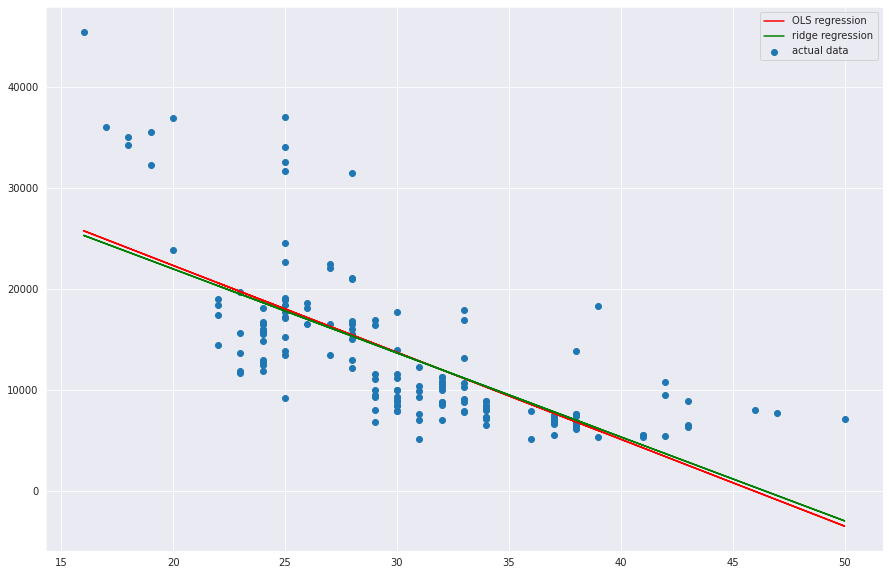

In [17]:
# additional image for understanding
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x_train.highwaympg, y_train, label="actual data")
ax.plot(x_train.highwaympg, ols_model.predict(x_train), color="red", label="OLS regression")
ax.plot(x_train.highwaympg, y_hat_train, color="green", label="ridge regression")
ax.legend()
fig.show()

# Побудова нелінійної моделі

Побудуємо модель вигляду

$Y = a X^{-1} + b +\epsilon$

1. Перетворення регресорів
2. Побудова ОНК

In [18]:
x_new = 1 / x

x_new_train, x_new_test = train_test_split(
    x_new,
    test_size=0.2,
    random_state=42
)

x_new_train = sm.add_constant(x_new_train)
x_new_test  = sm.add_constant(x_new_test)

In [19]:
nonlinear_model = sm.OLS(y_train, x_new_train).fit()
nonlinear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     273.7
Date:                Thu, 06 Apr 2023   Prob (F-statistic):           1.24e-36
Time:                        19:34:55   Log-Likelihood:                -1619.7
No. Observations:                 164   AIC:                             3243.
Df Residuals:                     162   BIC:                             3250.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.433e+04   1706.257     -8.400      0.000   -1.77e+04    -1.1e+04
highwaympg  8.048e+05   4.86e+04     16.543      0.000    7.09e+05    9.01e+05
==============================================================================
Omnibus:                       51.452   Durbin-Watson:                   2.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.310
Skew:                           1.382   Prob(JB):                     1.51e-25
Kurtosis:                       6.014   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
metrics.r2_score(y_test, nonlinear_model.predict(x_new_test))

0.6175980064412601

In [21]:
y_new_hat_train = nonlinear_model.predict(x_new_train)

/home/olga/Projects/CPI/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


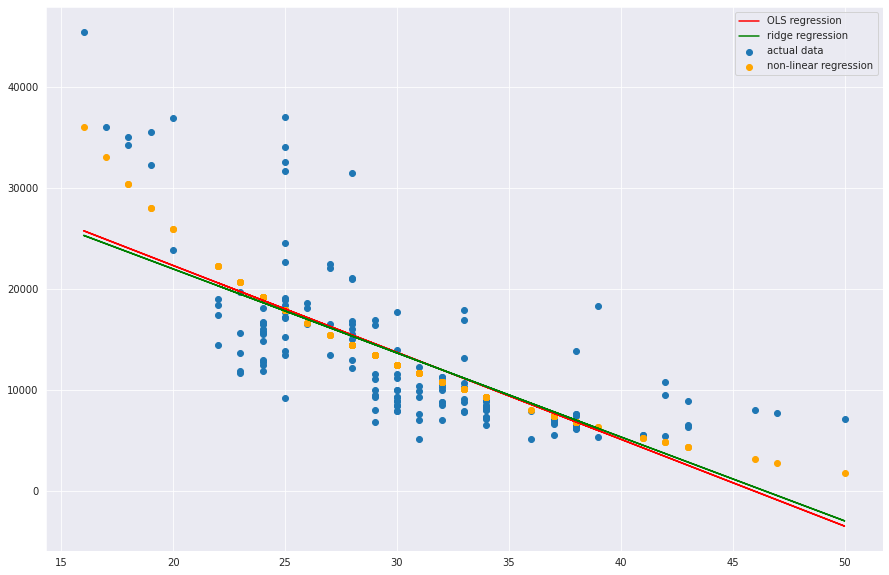

In [22]:
# additional image for understanding
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(x_train.highwaympg, y_train, label="actual data")
ax.plot(x_train.highwaympg, ols_model.predict(x_train), color="red", label="OLS regression")
ax.plot(x_train.highwaympg, y_hat_train, color="green", label="ridge regression")
ax.scatter(x_train.highwaympg, y_new_hat_train, color="orange", label="non-linear regression")
ax.legend()
fig.show()

# Бонус: кількість і якість регресорів

1. Нащо регулювати кількість регресорів?
    - аби прибрати мультиколінеарність
    - аби пришвидшити тренування і роботу моделі
2. Чому ми маємо брати до уваги мультиколінеарність?
    - якщо метою регресійного аналізу є дослідження характеру взаємозв'язків, то мультиколінеарність може призвести до хибних висновків.
3. Нащо пришвидшувати модель, якщо у мене RTX 3080?
    - на великих датасетах і в промислових масштабах потрібно, щоб модель тренувалася, а згодом і працювала якомога швидше. При цьому чим більше коштів буде зекономлено на тренуванні, тим більшу премію ви потенційно зможете отримати в кінці року.
4. Які є способи регулювати кількість регресорів?
    - регресія на головні компоненти
    - вилучення регресорів

## Регресія на головні компоненти

(так це ж було вже!)

Подивитися можна за посиланням:
https://github.com/gamble27/assist-practice-2023/blob/main/lesson_1/presentation.ipynb

## Вилучення деяких регресорів

В таких випадках допомагає кореляційна матриця. Якщо 2 регресори сильно корелюють між собою і відгуком, це може свідчити і про такі види зв'язку між змінними:

1. x1 => x2 => y
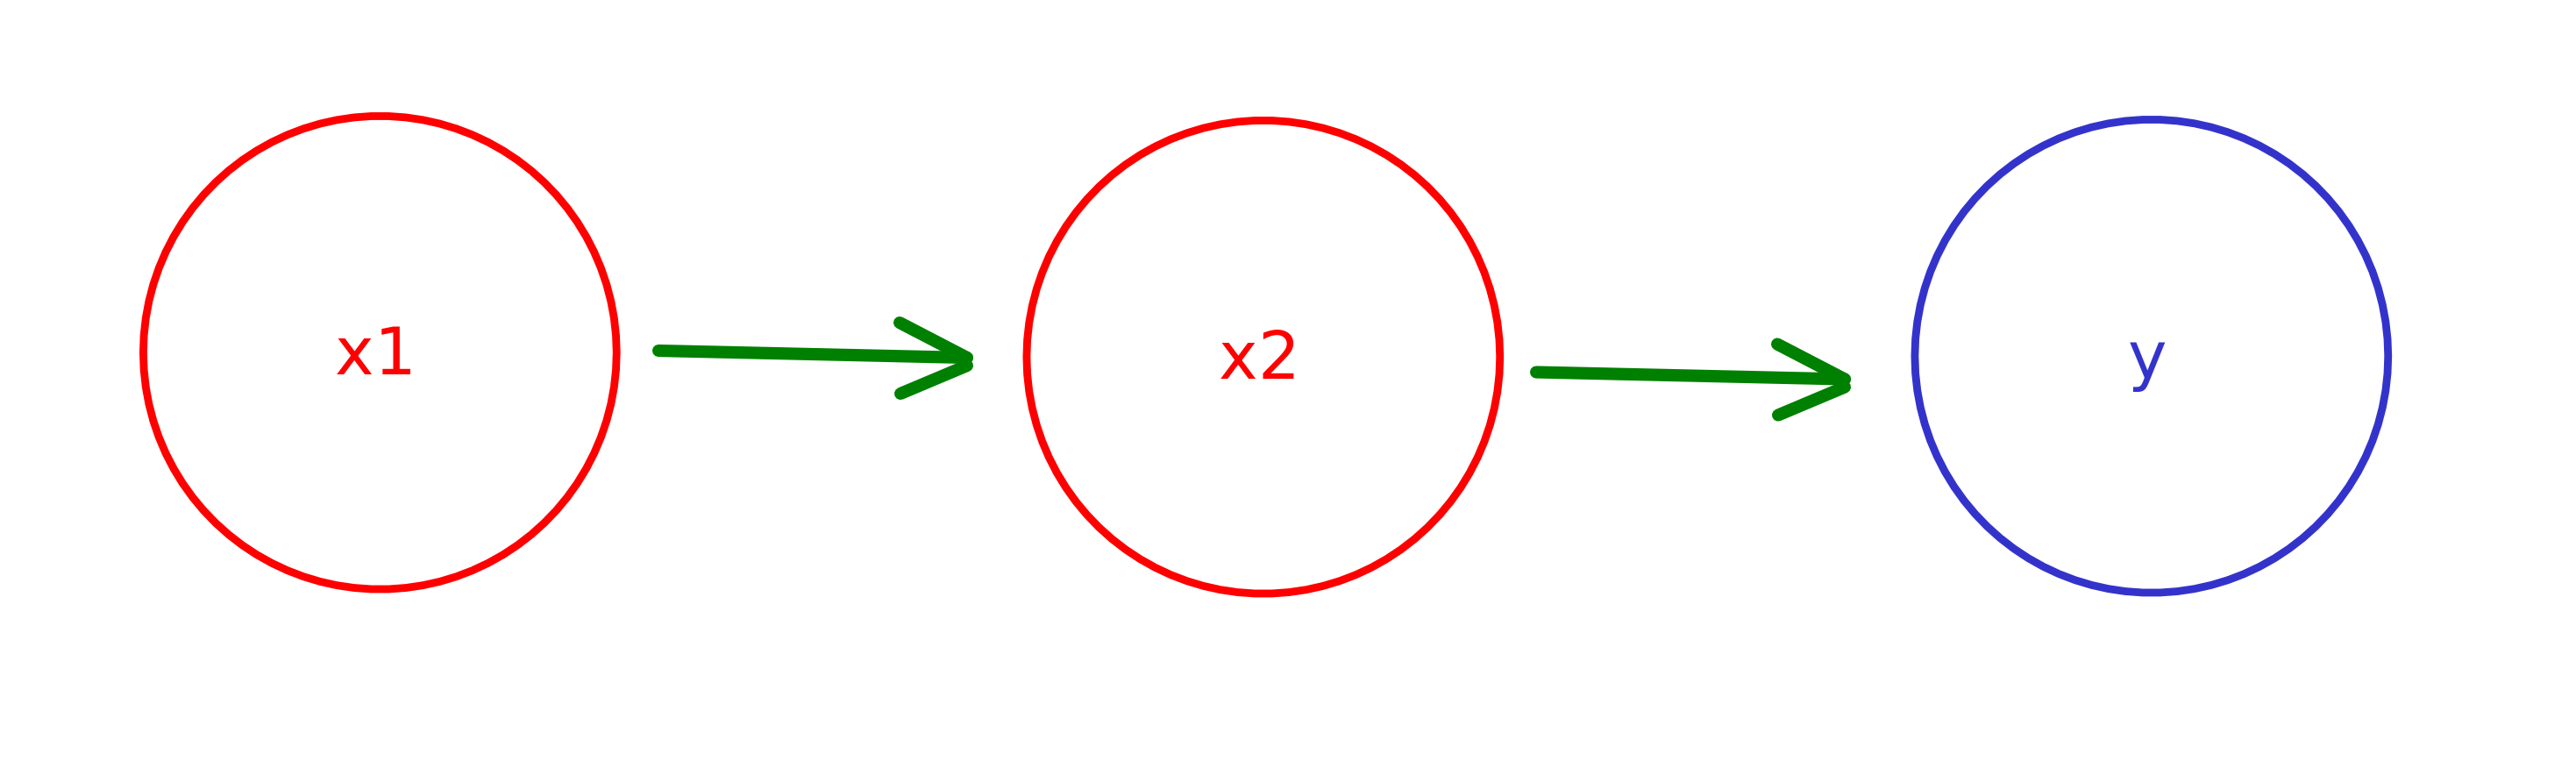
2. x0 => x1, x2, y
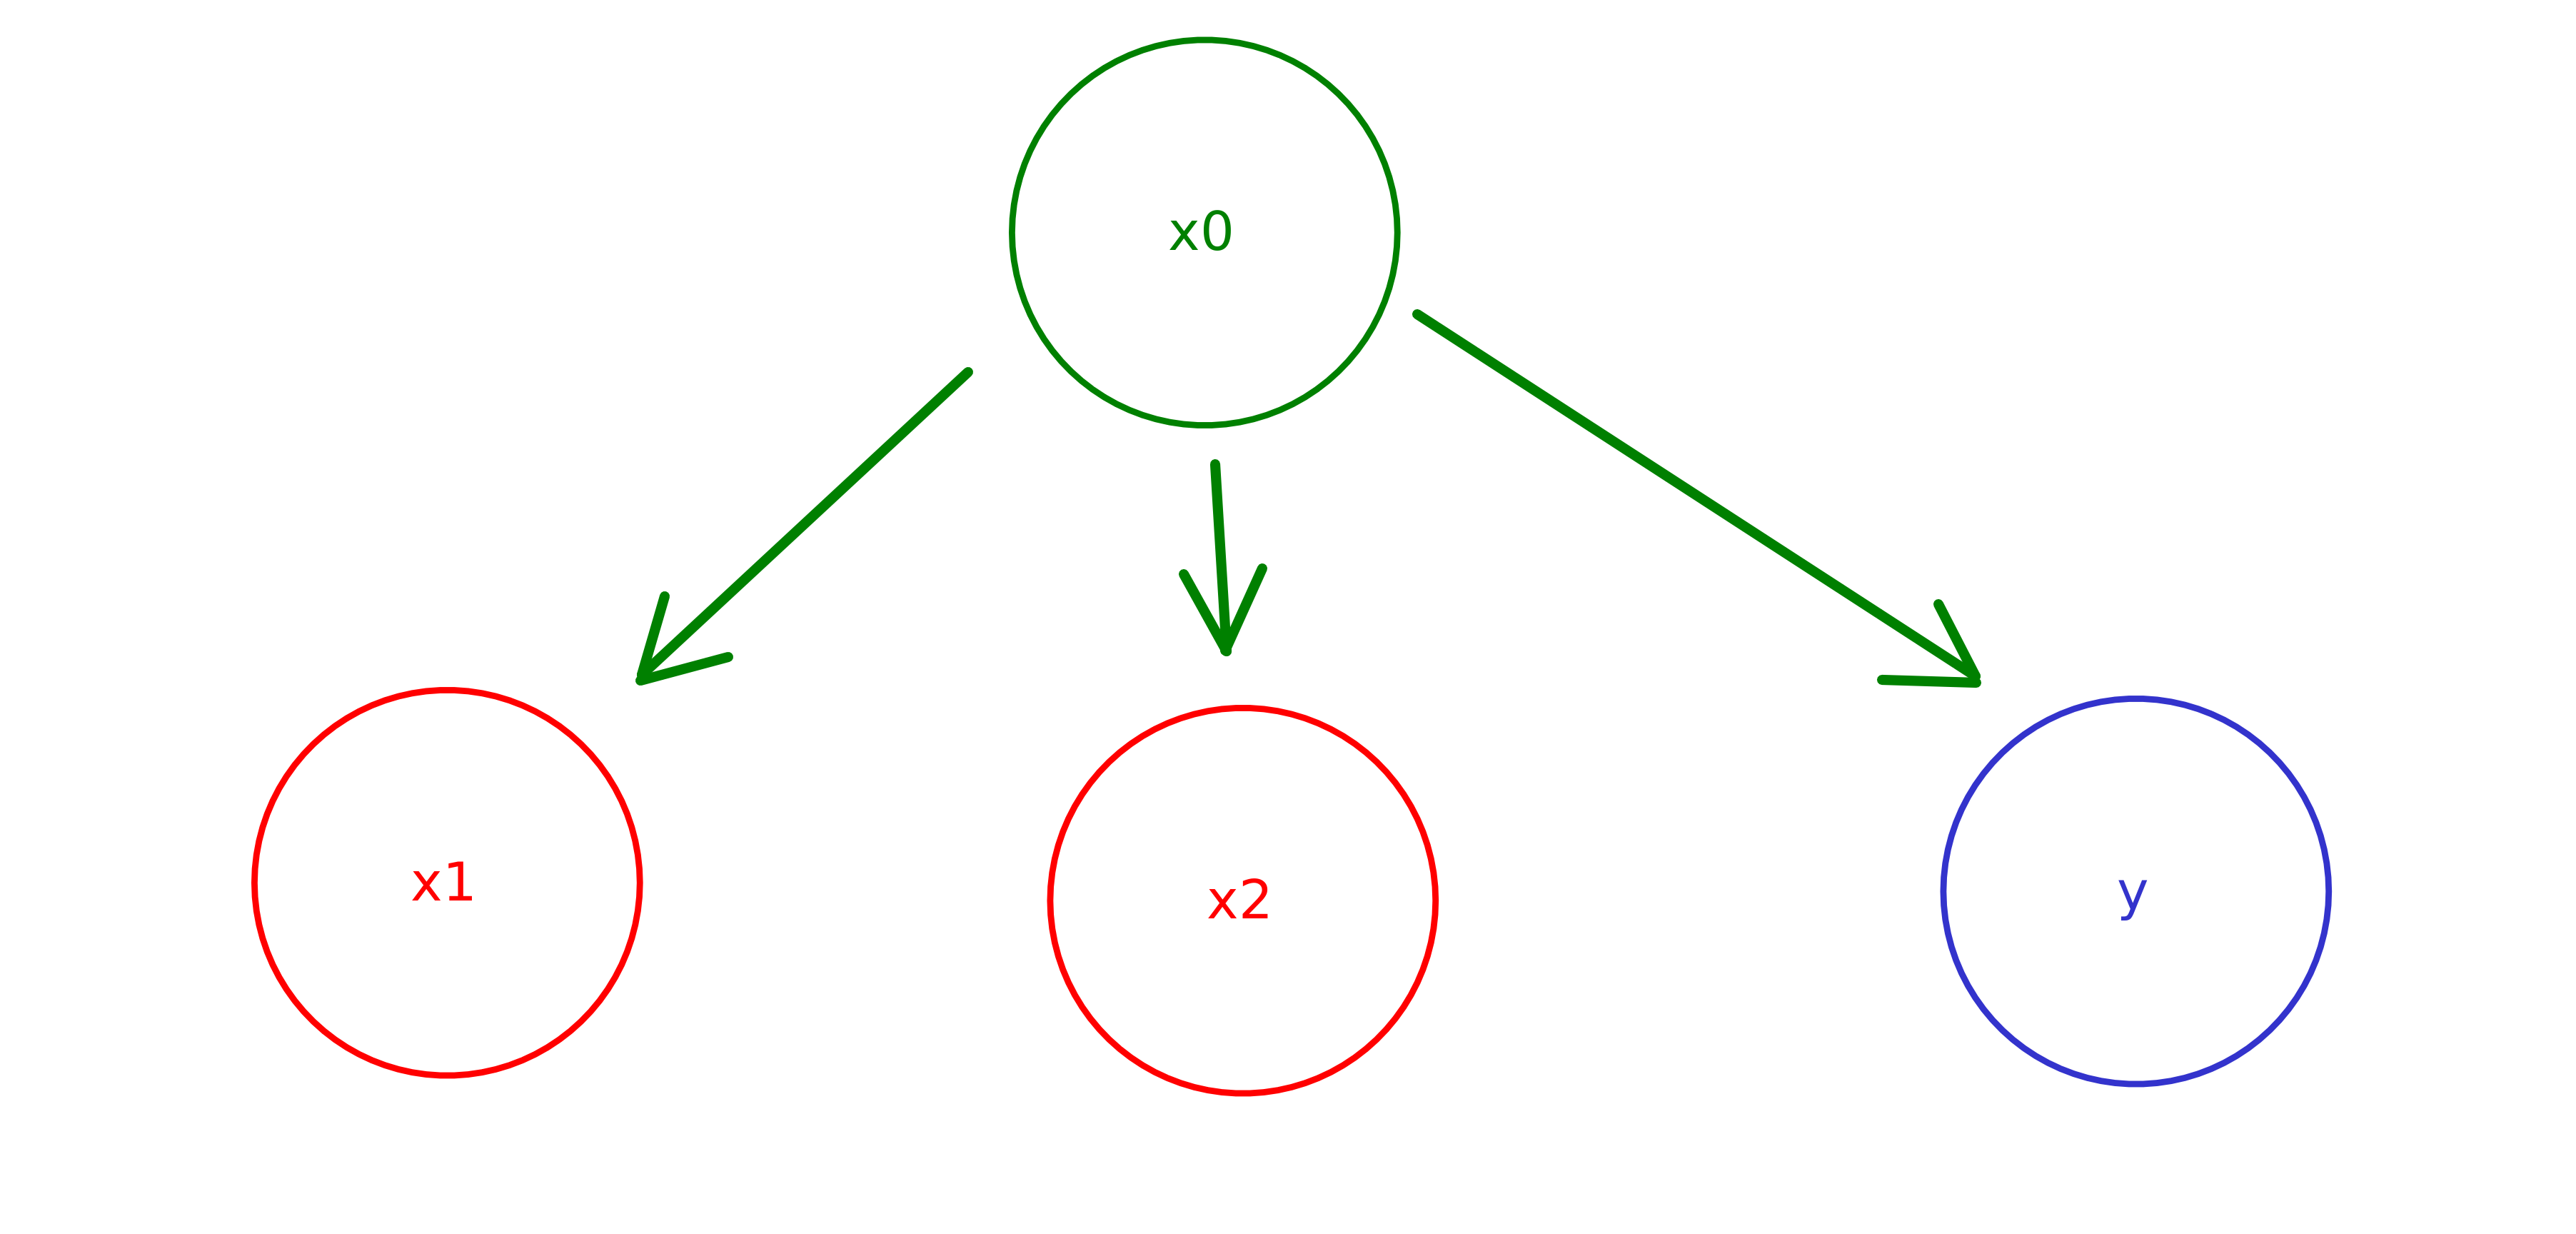
3. x0 => x1, x2; x2 => y
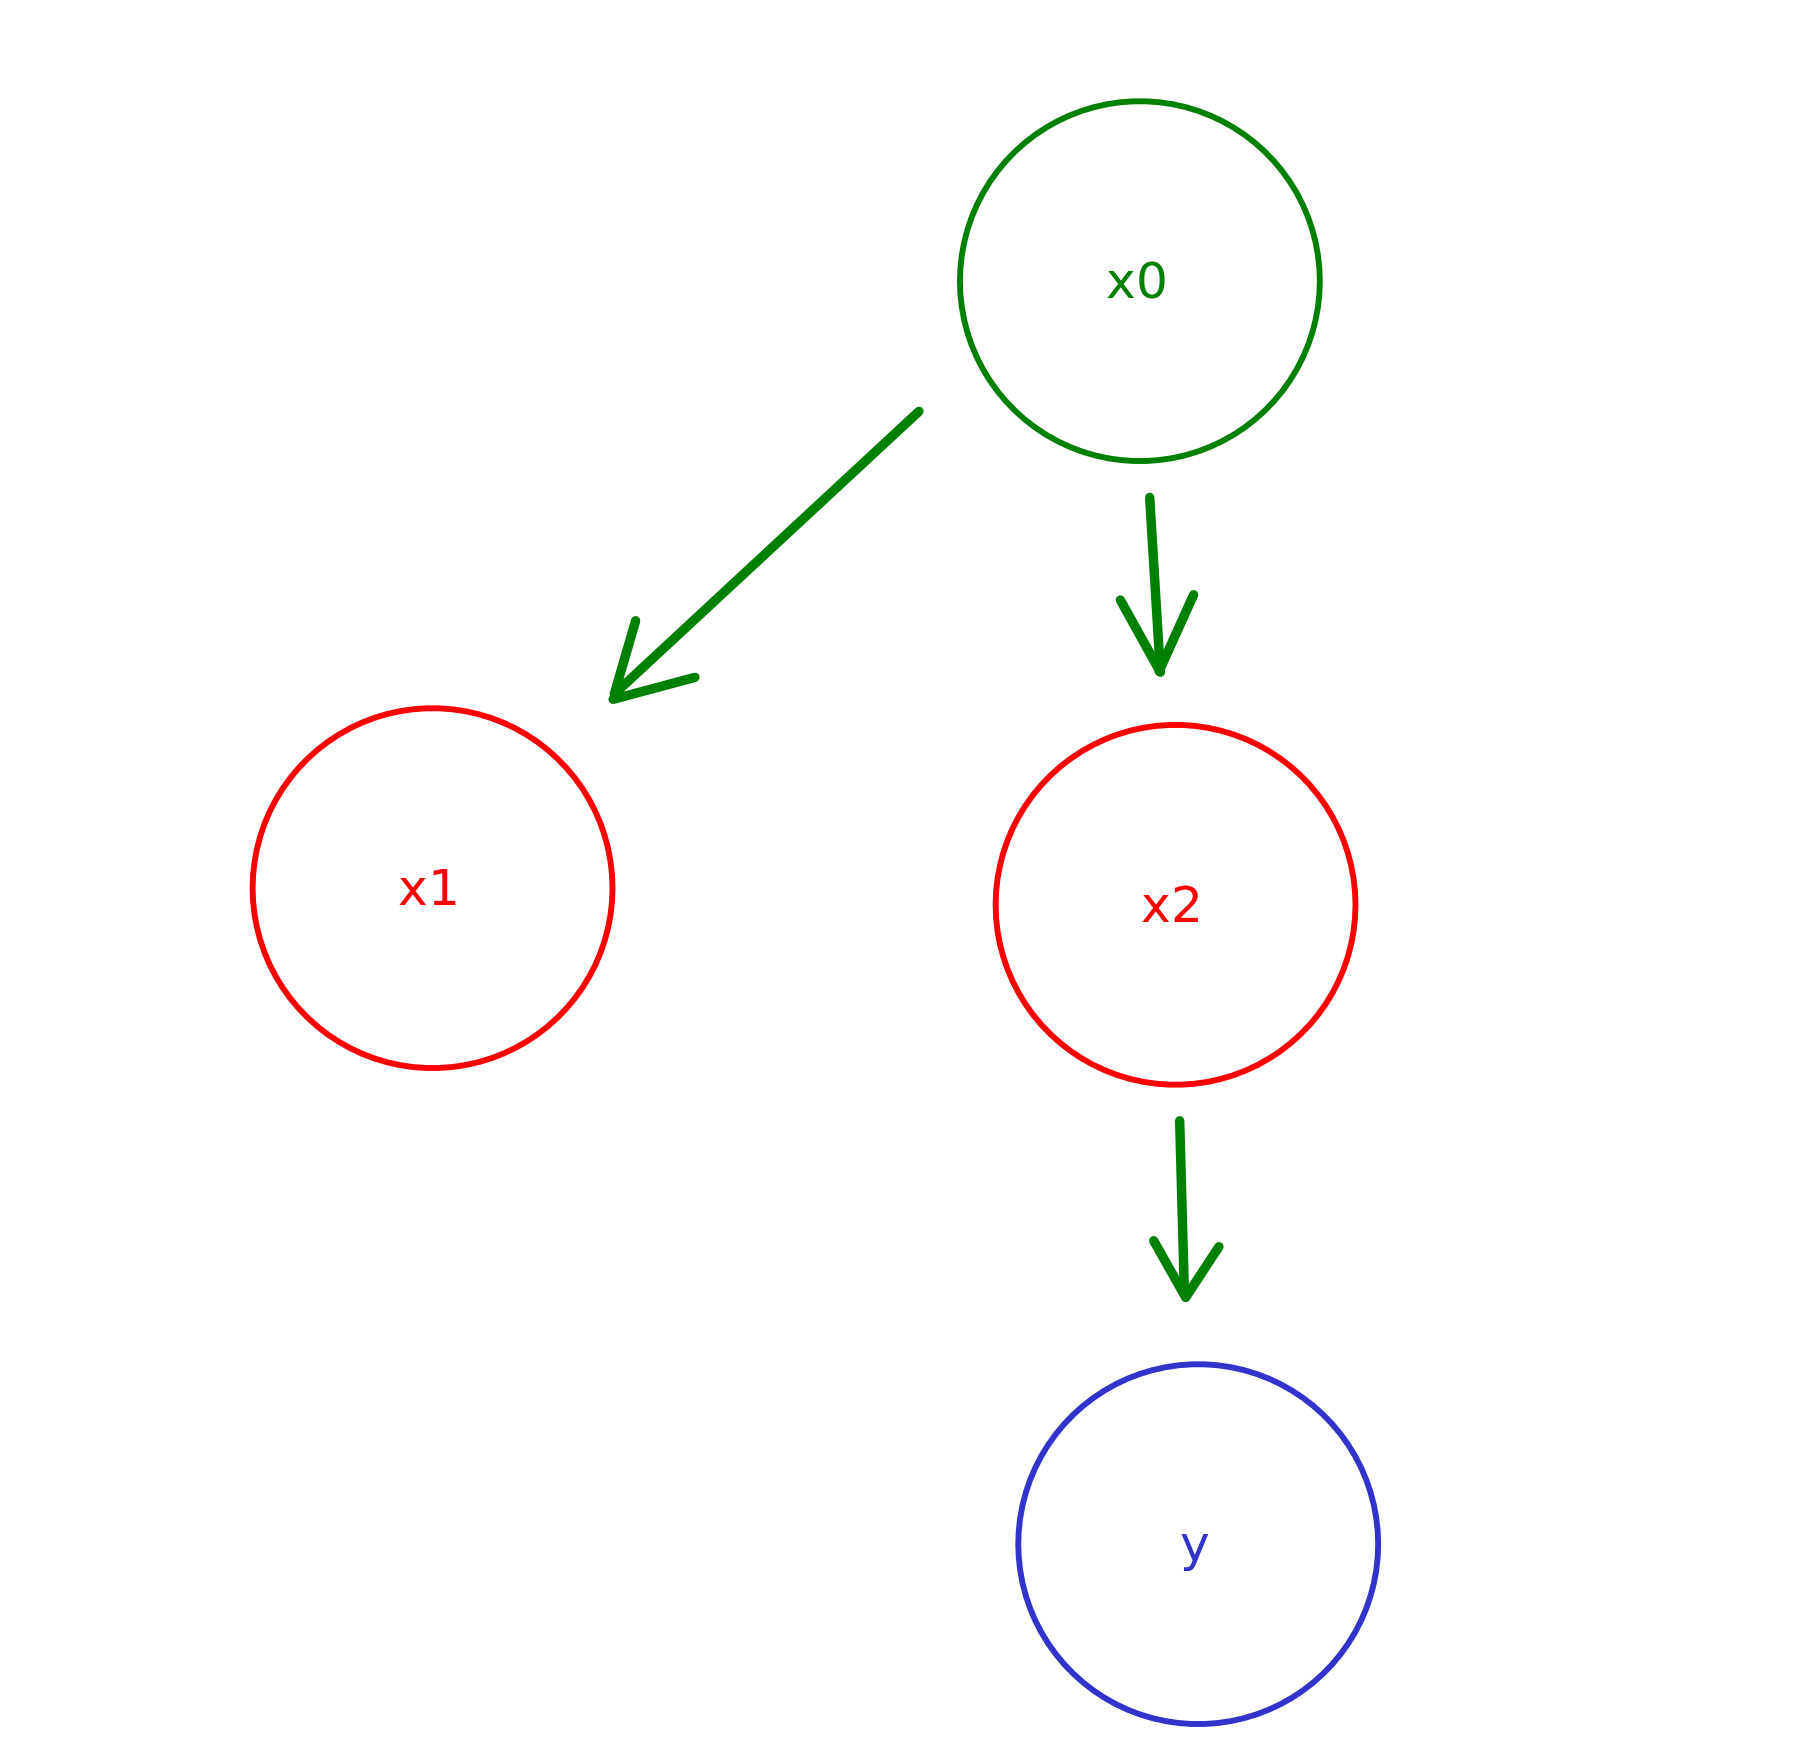

В такому випадку вилучення х1 або х2 чи пошук х0 і вилучення х1,х2 може покращити якість моделі

In [23]:
# corrplot
def corrplot(df):
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # plot
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, mask=mask, annot=True, xticklabels=True, yticklabels=True)
    plt.show()

In [24]:
data = cars[[
    # регресори
    'highwaympg', 'citympg', 'peakrpm', 'horsepower',
    'compressionratio', 'boreratio', 'stroke',
    'enginesize', 'curbweight', 'carheight',
    'carwidth','carlength', 'wheelbase',
    # відгук
    'price'
]]

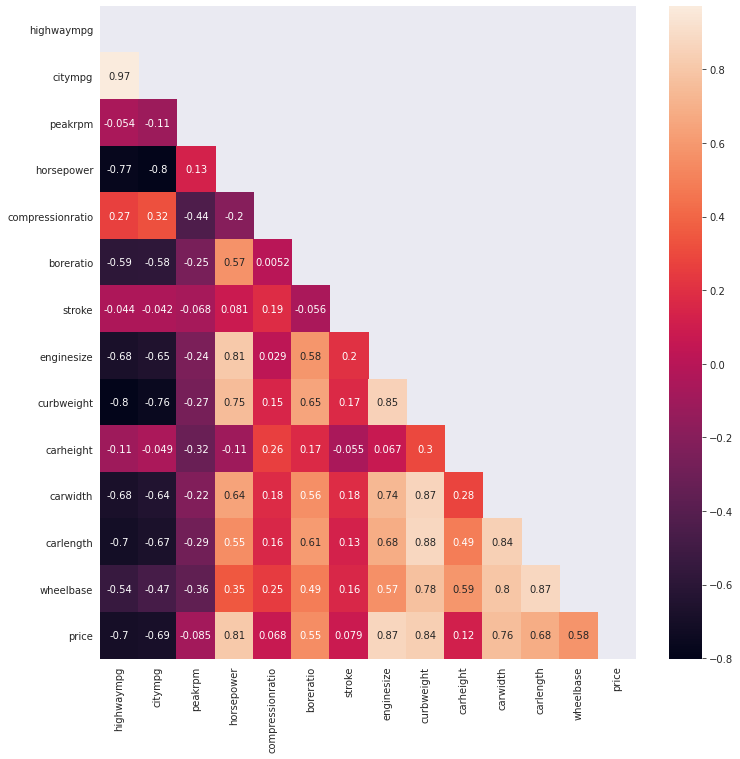

In [25]:
corrplot(data)